In [ ]:
# @title ###### Licensed to the Apache Software Foundation (ASF), Version 2.0 (the "License")

# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements. See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership. The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied. See the License for the
# specific language governing permissions and limitations
# under the License

# Use Gemma to gauge sentiment and summarize conversations

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/apache/beam/blob/master/examples/notebooks/beam-ml/gemma_2_sentiment_and_summarization.ipynb"><img src="https://raw.githubusercontent.com/google/or-tools/main/tools/colab_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/apache/beam/blob/master/examples/notebooks/beam-ml/gemma_2_sentiment_and_summarization.ipynb"><img src="https://raw.githubusercontent.com/google/or-tools/main/tools/github_32px.png" />View source on GitHub</a>
  </td>
</table>

Gemma is a family of lightweight, state-of-the art open models built from research and technology used to create the Gemini models. You can use Gemma models in your Apache Beam inference pipelines.

Because large language models (LLMs) like Gemma are versatile, you can integrate them into business processes. The example in this notebook demonstrates how to use Gemma to gauge the sentiment of a conversation, summarize that conversation's content, and draft a reply for a difficult conversation. The system allows a person to review the reply before it's sent to customers. For more information, see the blog post [Gemma for Streaming ML with Dataflow](https://developers.googleblog.com/en/gemma-for-streaming-ml-with-dataflow).

A requirement of this work is that customers who express a negative sentiment receive a reply in near real-time. As a result, the workflow needs to use a streaming data pipeline with an LLM that has minimal latency.

## Use case

An example use case is a bustling food chain grappling with analyzing and storing a high volume of customer support requests. Customer interactions include both chats generated by automated chatbots and nuanced conversations that require the attention of live support staff.

### Requirements

To address both types of interactions, the workflow has the following requirements.

- It needs to efficiently manage and store chat data by summarizing positive interactions for easy reference and future analysis.

- It must use real-time issue detection and resolution.

- Sentiment analysis must identify dissatisfied customers and generate tailored responses to address their concerns.

### Workflow

To meet these requirements, the pipeline processes completed chat messages in near real time. First, the pipeline uses Gemma to monitor the sentiment of the customer chats. All chats are then summarized, with positive or neutral sentiment chats sent directly to a data platform, BigQuery, by using the available Dataflow I/Os.

For chats that have a negative sentiment, the Gemma model crafts a contextually appropriate response for the customer. This response is sent to a human for review so that they can refine the message before it reaches the customer.

This example addresses important complexities inherent in using an LLM within a pipeline. For example, processing the responses in code is challenging because of the non-deterministic nature of the text. In this example, the workflow requires the LLM to generate JSON responses, which is not the default format. The worklow needs to parse and validate the response, a process similar to processing data from sources that don't always have correctly structured data.

This workflow allows businesses to respond to customers faster and to provide personalized responses when needed.

- The automation of positive chat summarization allows support staff to focus on more complex interactions.
- The scalability of the system makes it possible to adapt to increasing chat volumes without compromising response quality.

You can also use the in-depth analysis of chat data to drive data-driven decision-making.

## The data processing pipeline

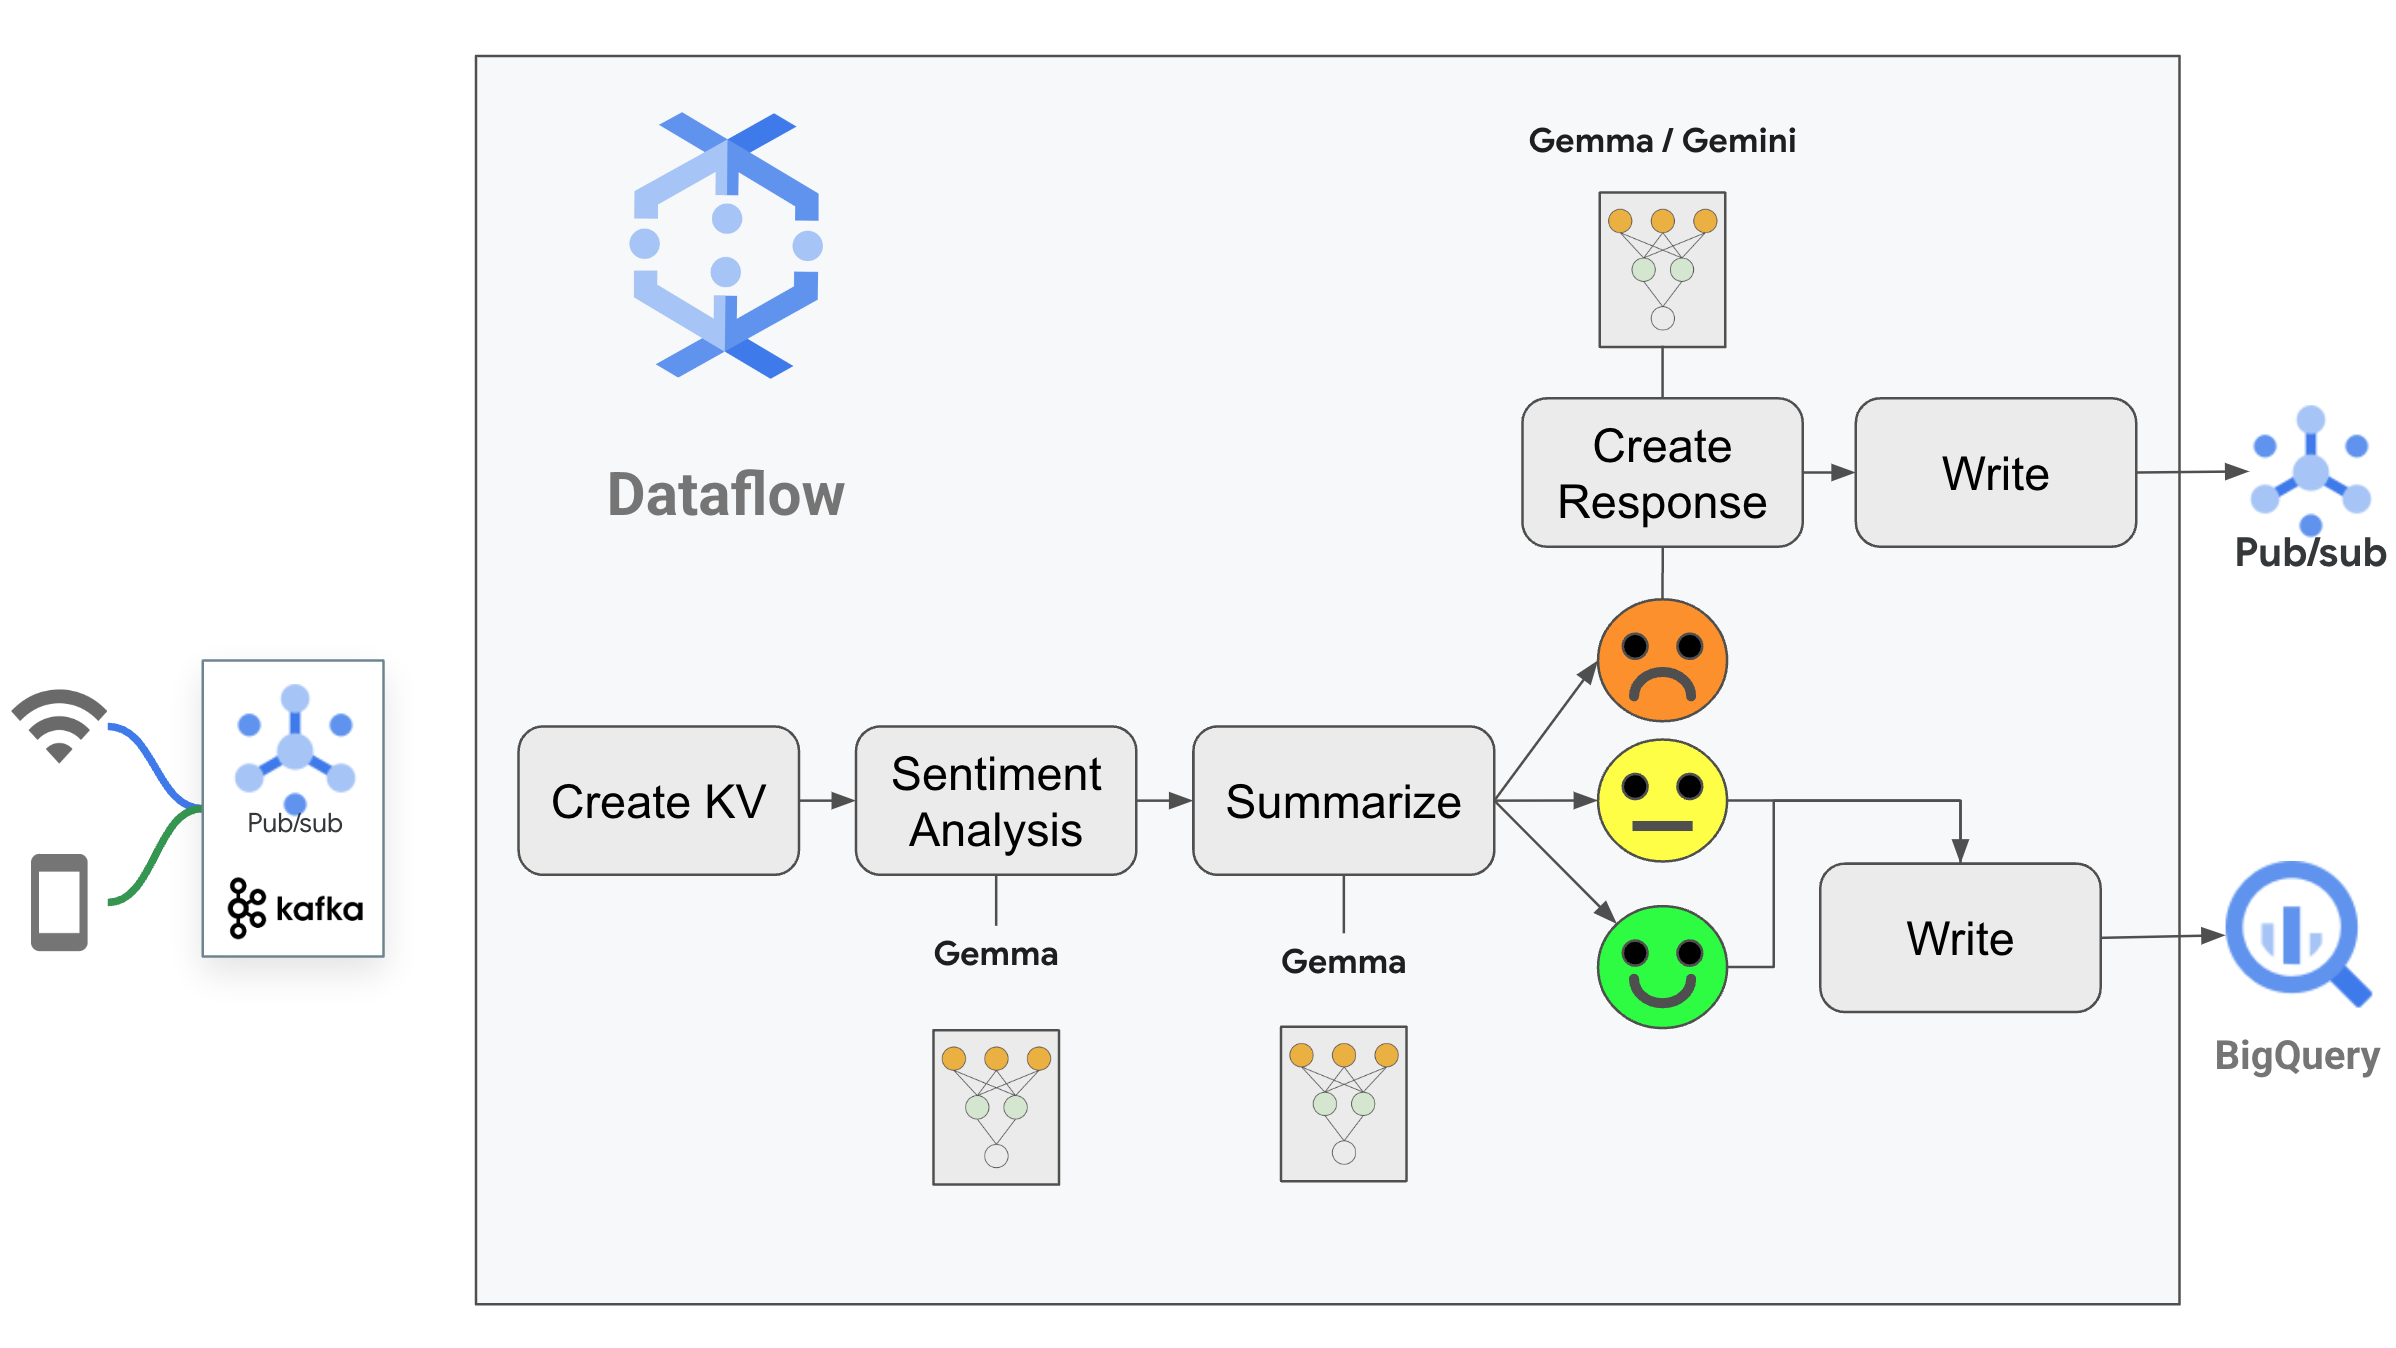

At a high level, the pipeline has the following steps:

1. Read the review data from Pub/Sub, the event messaging source. This data contains the chat ID and the chat history as a JSON payload. This payload is processed in the pipeline.
1. Pass the text from the messages to Gemma with a prompt.
1. The pipeline requests that the model complete the following two tasks:
   *  Attach a sentiment score to the message, by using one of the following three values: `1` for a positive chat, `0` for a neutral chat, and `-1` for a negative chat.
   *  Provide a one-sentence summary of the chat.
1. The pipeline branches, depending on the sentiment score:
   * If the score is `1` or `0`, the chat and its summarization are sent to a data analytics system for storage and future analysis.
   * If the score is `-1`, the Gemma model drafts a response. This response and the chat information are sent to an event messaging system that connects the pipeline and other applications. This step allows a person to review the content of the response.  

## Build the pipeline

This section provides the code needed to run the pipeline.

### Before you begin

Although you can use CPUs for testing and development, for a production Dataflow ML system we recommend that you use GPUs. When you use GPUs with Dataflow, we recommend that you use a custom container. For more information about configuring GPUs and custom containers with Dataflow, see [Best practices for working with Dataflow GPUs](https://cloud.google.com/dataflow/docs/gpu/develop-with-gpus). To faciliate rapid testing of the pipeline, follow the guide [Run a pipeline with GPUs](https://cloud.google.com/dataflow/docs/gpu/use-gpus). The guide includes the steps needed to build the container image.

After you configure your environment, download the model [gemma2_instruct_2b_en](https://www.kaggle.com/models/google/gemma-2/keras) into a folder. In this example, the folder is named `gemma2`.

### Build the base image

Add the following Dockerfile to your folder, and then build the base image. Use the Dockerfile to build the image as you create the `pipeline.py` file. The images are broken into two groups to facilitate testing and development.

```sh
ARG SERVING_BUILD_IMAGE=tensorflow/tensorflow:2.16.1-gpu

FROM ${SERVING_BUILD_IMAGE}
WORKDIR /workspace

COPY gemma2  gemma2
RUN apt-get update -y && apt-get install -y cmake && apt-get install -y vim
```

When testing the pipeline code and when launchig the job on Dataflow, test and launch from inside the container. This step prevents dependency mismatches when running the pipeline on Dataflow.

The `requirements.txt` file contains the following dependencies:  

```sh
apache_beam[gcp]==2.54.0
keras_nlp==0.14.3
keras==3.4.1
jax[cuda12]
```

The next step includes the files needed to construct the pipeine. The content of the `pipeline.py` file are contained in a later section of this notebook.

Replace DOCKERFILE_IMAGE with the image that you built using the first Dockerfile.

```sh
FROM <DOCKERFILE_IMAGE>

WORKDIR /workspace

# Copy files from the official SDK image, including the script and dependencies.
COPY --from=apache/beam_python3.11_sdk:2.54.0 /opt/apache/beam /opt/apache/beam


COPY requirements.txt requirements.txt
RUN pip install --upgrade --no-cache-dir pip \
    && pip install --no-cache-dir -r  requirements.txt

# Copy the model directory downloaded from Kaggle and the pipeline code.
COPY pipeline.py pipeline.py

# The colab was tested and run with a JAX backend to let Dataflow workers
# pick up the environment needed to include in the Env of the image.
ENV KERAS_BACKEND="jax"
ENV XLA_PYTHON_CLIENT_MEM_FRACTION="0.9"


# Set the entrypoint to the Apache Beam SDK launcher.
ENTRYPOINT ["/opt/apache/beam/boot"]
```

### Run the pipeline

The following code creates and runs the pipeline.

- The `pip install` steps are needed to run the code in the notebook, but aren't needed when running the code in your container.

- Without a GPU, the inference takes a long time to complete.

In [ ]:
%pip install apache_beam[gcp]=="2.54.0" keras_nlp=="0.14.3" keras=="3.5.0" jax[cuda12]

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # Or "tensorflow" or "torch".
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.9"

import keras
import keras_nlp
import numpy as np
import json
import ast
import re
import logging

import apache_beam as beam
from apache_beam.ml.inference import utils
from apache_beam.ml.inference.base import RunInference
from apache_beam.options import pipeline_options
from apache_beam.options.pipeline_options import GoogleCloudOptions
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options.pipeline_options import SetupOptions
from apache_beam.options.pipeline_options import StandardOptions
from apache_beam.options.pipeline_options import WorkerOptions
from apache_beam.ml.inference import utils
from apache_beam.ml.inference.base import ModelHandler
from apache_beam.ml.inference.base import PredictionResult
from apache_beam.ml.inference.base import KeyedModelHandler
from keras_nlp.models import GemmaCausalLM
from typing import Any, Dict, Iterable, Optional, Sequence

Set pipeline options and provide the input Pub/Sub topic. The options that are commented out enable running the pipeline on Dataflow.

In [ ]:
options = PipelineOptions()
options.view_as(StandardOptions).streaming = True
options.view_as(SetupOptions).save_main_session = True

# options.view_as(StandardOptions).runner = "dataflowrunner"
# options.view_as(GoogleCloudOptions).project = <PROJECT>
# options.view_as(GoogleCloudOptions).temp_location= <TMP LOCATION>
# options.view_as(GoogleCloudOptions).region= "us-west1"
# options.view_as(WorkerOptions).machine_type= "g2-standard-4"
# options.view_as(WorkerOptions).worker_harness_container_image = <IMAGE YOU BUILT>
# options.view_as(WorkerOptions).disk_size_gb=200
# options.view_as(GoogleCloudOptions).dataflow_service_options=["worker_accelerator=type:nvidia-l4;count:1;install-nvidia-driver"]

topic_reviews="<PubSub Topic>"

Define a custom model handler that loads the Gemma model and handles inference calls.

In [ ]:
class GemmaModelHandler(ModelHandler[str,
                                     PredictionResult,GemmaCausalLM
                                     ]):
    def __init__(
        self,
        model_name: str = "",
    ):
        """ Implementation of the ModelHandler interface for Gemma using text as input.

        Example Usage::

          pcoll | RunInference(GemmaModelHandler())

        Args:
          model_name: The Gemma model uri.
        """
        self._model_name = model_name
        self._env_vars = {}
    def share_model_across_processes(self)  -> bool:
        """Returns whether to share a single model in memory across processes.

        This is useful when the loaded model is large, preventing potential
        out-of-memory issues when running the pipeline.

        Returns:
          bool
        """
        return True

    def load_model(self) -> GemmaCausalLM:
        """Loads and initializes a model for processing."""
        return keras_nlp.models.GemmaCausalLM.from_preset(self._model_name)

    def run_inference(
        self,
        batch: Sequence[str],
        model: GemmaCausalLM,
        inference_args: Optional[Dict[str, Any]] = None
    ) -> Iterable[PredictionResult]:
        """Runs inferences on a batch of text strings.

        Args:
          batch: A sequence of examples as text strings.
          model:
          inference_args: Any additional arguments for an inference.

        Returns:
          An Iterable of type PredictionResult.
        """
        # Loop each text string, and use a tuple to store the inference results.
        predictions = []
        for one_text in batch:
            result = model.generate(one_text, max_length=1024)
            predictions.append(result)
        return utils._convert_to_result(batch, predictions, self._model_name)

Define a prompt template. The template formats inputs and instructs the model on the task. This block also contains an example input to the model.

In [ ]:
prompt_template = """
<prompt>
Provide the results of doing these two tasks on the chat history provided below for the user {}
task 1 : assess if the tone is happy = 1 , neutral = 0 or unhappy = -1
task 2 : summarize the text with a maximum of 512 characters
Return the answer as a JSON string with fields [sentiment, summary] do NOT explain your answer

@@@{}@@@
<answer>
"""
chat_text = """
id 221: Hay I am really annoyed that your menu includes a pizza with pineapple on it!
id 331: Sorry to hear that , but pineapple is nice on pizza
id 221: What a terriable thing to say! Its never ok, so unhappy right now!
"""

# Example input
chat =json.dumps({"id" : 42, "user_id" : 221 , "chat_message" : chat_text})
print(chat)

Define pre- and post-processing functions. The `CreatePrompt` class creates a key-value pair that contains the chat ID and the formatted prompt. The `extract_model_reply` function parses the response, extracting the JSON string requested from the model. The LLM is not guaranteed to return a JSON-formatted object. If the reply is malformed, the code produces an exception. This helper is used in the `SentimentAnalysis` class `DoFn` to split out the sentiment score and the summary of the text. The sentiment score is then used to tag the output, allowing the pipeline to handle different sentiments in different ways.

In [ ]:
keyed_model_handler = KeyedModelHandler(GemmaModelHandler('gemma_2'))

# Create the prompt by using the information from the chat.
class CreatePrompt(beam.DoFn):
  def process(self, element, *args, **kwargs):
    user_chat = json.loads(element)
    chat_id = user_chat['id']
    user_id = user_chat['user_id']
    messages = user_chat['chat_message']
    yield (chat_id, prompt_template.format(user_id, messages))

def extract_model_reply(model_inference):
    print(model_inference)
    match = re.search(r"(\{[\s\S]*?\})", model_inference)
    json_str = match.group(1)
    print(json_str)
    result = json.loads(json_str)
    if all(key in result for key in ['sentiment', 'summary']):
        return result
    raise Exception('Malformed model reply')

    # @title
class SentimentAnalysis(beam.DoFn):
    def process(self, element):
        key = element[0]
        match = re.search(r"@@@([\s\S]*?)@@@", element[1].example)
        chats = match.group(1)

        try:
            # The result contains the prompt. Replace the prompt with "".
            result = extract_model_reply(element[1].inference.replace(element[1].example, ""))
            processed_result = (key, chats, result['sentiment'], result['summary'])

            if (result['sentiment'] ==-1):
              output = beam.TaggedOutput('negative', processed_result)
            else:
              output = beam.TaggedOutput('main', processed_result)

        except Exception as err:
            print("ERROR!" + str(err))
            output = beam.TaggedOutput('error', element)

        yield output

gemma_inference = RunInference(keyed_model_handler)

To run the pipeline, use the following code. To use the example chat input created previously, instead of a custom Pub/Sub source, use `chats = p | beam.Create([chat])` instead of the Pub/Sub read.

In [ ]:

with beam.Pipeline(options=options) as p:
  chats = (p | "Read Topic" >>
            beam.io.ReadFromPubSub(subscription=topic_reviews)
            | "Parse" >> beam.Map(lambda x: x.decode("utf-8")))
  prompts = chats | "Create Prompt" >> beam.ParDo(CreatePrompt())
  results = prompts | "RunInference-Gemma" >> gemma_inference
  filtered_results = results | "Process Results" >> beam.ParDo(SentimentAnalysis()).with_outputs('main','negative','error')
  generated_responses = (
      filtered_results.negative
       | "Generate Response" >> beam.Map(lambda x: ((x[0], x[3]), "<prompt>Generate an appology reponse for the user in this chat text: " + x[1] + "<answer>"))
       | "Gemma-Response" >> gemma_inference
       )

  generated_responses | "Print Reponse" >> beam.Map(lambda x: logging.info(x))
  filtered_results.main | "Print Main" >> beam.Map(lambda x: logging.info(x))
  filtered_results.error | "Print Errors" >> beam.Map(lambda x: logging.info(x))